In [1]:
import numpy as np
import pyroomacoustics as pra

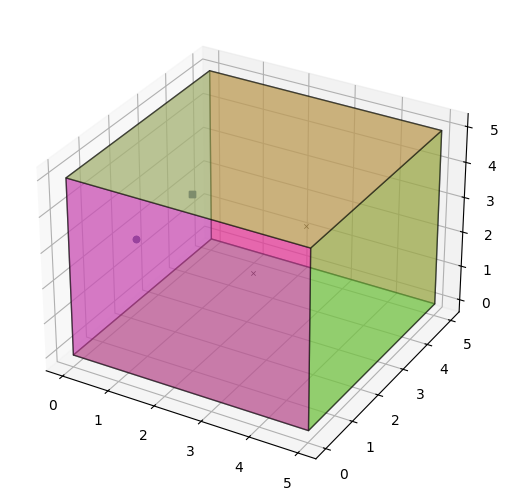

In [21]:
import numpy as np
import pyroomacoustics as pra
import matplotlib.pyplot as plt

# Create Room
room_dim = [5, 5, 5]
room = pra.ShoeBox(room_dim, fs=16_000, absorption=0.2, max_order=15)

# Place the Speakers
speakers = np.array([
    [0.5, 1.5, 2.5],
    [0.5, 3.5, 2.5] 
]).T

for loc in speakers.T:
    room.add_source(loc)

# 2. Place the Zones (Side-by-side on the right)
# Bright Zone: Top Right
mics_bright = np.array([
    [3.0, 1.5, 2.5]
]).T

# Dark Zone: Bottom Right
mics_dark = np.array([
    [3.0, 3.5, 2.5]
]).T

# Combine and Add to Room
all_mics = np.concatenate((mics_bright, mics_dark), axis=1)
room.add_microphone_array(pra.MicrophoneArray(all_mics, room.fs))

# 5. Plot
fig, ax = room.plot()
plt.show()

Generated RIRs for 2 mics and 2 sources.


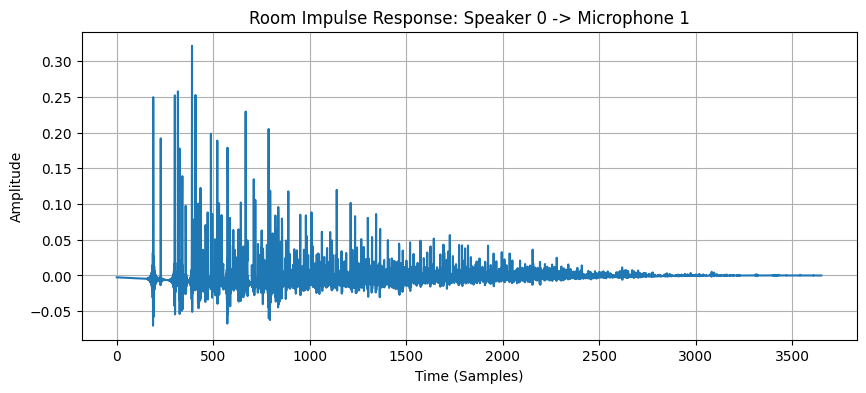

In [24]:
# Compute the Room Impulse Response
room.compute_rir()
num_mics = len(room.rir)
num_sources = len(room.rir[0])
print(f"Generated RIRs for {num_mics} mics and {num_sources} sources.")

# Plot a specific RIR mic-speaker
speaker_i = 0
mic_i = 1
plt.figure(figsize=(10, 4))
plt.plot(room.rir[mic_i][speaker_i])
plt.title(f"Room Impulse Response: Speaker {speaker_i} -> Microphone {mic_i}")
plt.xlabel("Time (Samples)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

In [ ]:
import numpy as np

# 1. Setup our target frequency
target_freq = 1000  # We want to create sound zones for a 1000 Hz tone
fs = room.fs        # 16000 Hz from our room setup

# Find the maximum length of all the RIRs to set our FFT size
max_rir_len = max([len(rir) for mic_rirs in room.rir for rir in mic_rirs])
n_fft = int(2**np.ceil(np.log2(max_rir_len))) # Next power of 2 for efficiency

# 2. Find the correct frequency bin
# The FFT divides the spectrum from 0 to fs/2 into (n_fft/2 + 1) bins
bin_idx = int(np.round(target_freq * n_fft / fs))
actual_freq = bin_idx * fs / n_fft
print(f"Target Freq: {target_freq} Hz | Actual Bin Freq: {actual_freq:.2f} Hz | Bin Index: {bin_idx}")

# 3. Initialize the H matrix
num_mics = len(room.mic_array)# 6 mics total (3 bright, 3 dark)
num_sources = len(room.sources)  # 3 speakers
print(f"Num mics: {num_mics} | Num sources: {num_sources}")
H = np.zeros((num_mics, num_sources), dtype=complex)

# 4. Populate the H matrix using the FFT
for i in range(num_mics):
    for j in range(num_sources):
        # Grab the time-domain impulse response
        h_time = room.rir[i][j]
        
        # Compute the real-valued FFT (rfft is optimized for real-number inputs)
        h_freq = np.fft.rfft(h_time, n=n_fft)
        
        # Pluck out the single complex scalar for our frequency and store it
        H[i, j] = h_freq[bin_idx]

print(f"\nShape of H matrix: {H.shape} (Rows=Mics, Cols=Speakers)")
print("\nHere are the complex scalars for Microphone 0 (Bright Zone) from all speakers:")
print(H[0, :])

Target Freq: 1000 Hz | Actual Bin Freq: 1000.00 Hz | Bin Index: 256
Num mics: 2 | Num sources: 2

Shape of H matrix: (2, 2) (Rows=Mics, Cols=Speakers)

Here are the complex scalars for Microphone 0 (Bright Zone) from all 3 speakers:
[-0.89572171+0.81118704j -0.48704296-0.2070678j ]
